In [26]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [27]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for category in os.listdir(folder):
            for filename in tqdm(os.listdir(os.path.join(folder,category))):
                img = cv2.imread(os.path.join(folder,category,filename))
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    labels.append(category)
    return np.array(images), np.array(labels)


In [28]:
train_folder = '/Users/nagib/Desktop/tu/cvpr/CIFAR-10-images-master/train'
test_folder = '/Users/nagib/Desktop/tu/cvpr/CIFAR-10-images-master/test'
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3096.81it/s]


['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


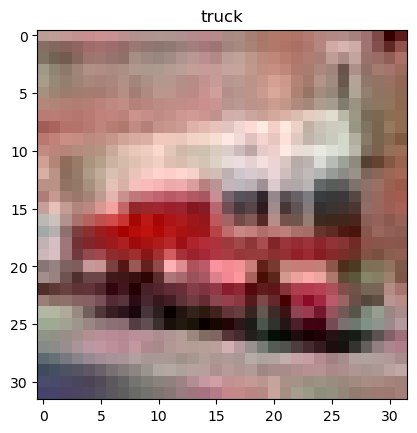

In [29]:
CATEGORIES = []
for c in os.listdir(train_folder):
    CATEGORIES.append(c)
print(CATEGORIES)

# select an image to view to know the right label
image_index = 11149


# display the image
plt.imshow(train_images[image_index])
plt.title(train_labels[image_index])
plt.show()

In [30]:
train_images = train_images / 255.0
test_images = test_images / 255.0
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


In [31]:
# set the number of samples to use for subsampling
num_training = 5000
num_testing = 500

# randomly select indices for subsampling
train_indices = np.random.choice(len(train_images), num_training , replace=False)
test_indices = np.random.choice(len(test_images), num_testing, replace=False)

# subsample the training and test data using the selected indices
train_images_sub = train_images[train_indices]
train_labels_sub = train_labels[train_indices]
X_train = train_images_sub
y_train = train_labels_sub

test_images_sub = test_images[test_indices]
test_labels_sub = test_labels[test_indices]

X_test = test_images_sub
y_test = test_labels_sub

# get the dimensions of the images
image_dim = train_images.shape[1:]

# flatten the images into 1D arrays
train_images_flat = train_images_sub.reshape(train_images_sub.shape[0], -1)
test_images_flat = test_images_sub.reshape(test_images_sub.shape[0], -1)

# print the new shapes of the flattened arrays
print("Training images shape (flat):", train_images_flat.shape)
print("Test images shape (flat):", test_images_flat.shape)

Training images shape (flat): (5000, 3072)
Test images shape (flat): (500, 3072)


In [32]:
class KNearestNeighbor(object):

  def __init__(self):
    pass

  def train(self, X, y):
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)
    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            dists[i, j] = np.sqrt(np.sum((X[i, :] - self.X_train[j, :]) **2))
    return dists

  def compute_distances_one_loop(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      dists[i, :] = np.sqrt(np.sum((self.X_train - X[i, :])**2, axis=1))
    return dists

  def compute_distances_no_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    dists = np.sqrt((-2 * np.dot(X, self.X_train.T)) + np.sum(X**2, axis=1, keepdims=True) + np.sum(self.X_train**2, axis=1))
    return dists

  def compute_l1_distances_two_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            dists[i, j] = np.sum((X[i, :] - self.X_train[j, :]))
    return dists

  def predict_labels(self, dists, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype=self.y_train.dtype)
    for i in range(num_test):
        k_nearest_idxs = np.argsort(dists[i, :])[:k]
        closest_y = self.y_train[k_nearest_idxs]
        label_count = {}
        for label in closest_y:
            if label in label_count:
                label_count[label] += 1
            else:
                label_count[label] = 1
        y_pred[i] = max(label_count, key=label_count.get)
    return y_pred

In [33]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances_two_loops(X_test)
print( dists.shape)

(500, 5000)


In [34]:
num_folds = 5
k_choices = [1, 3, 5, 9, 13, 15, 20]

X_train_folds = []
y_train_folds = []


random_list = random.sample(list(zip(X_train, y_train)), len(list(zip(X_train, y_train))))
X_train, y_train = zip(*random_list)

X_train_folds = np.array_split(X_train, num_folds, axis=0) # list
y_train_folds = np.array_split(y_train, num_folds, axis=0) # list

k_to_accuracies = {}

for i in range(num_folds):
    X_train_batch = np.concatenate(X_train_folds[1:num_folds])   
    y_train_batch = np.concatenate(y_train_folds[0:num_folds])
    
    X_valid_batch = X_train_folds[0]   
    y_valid_batch = y_train_folds[0]
    
    if i < num_folds - 1:
        tmp = X_train_folds[0]
        X_train_folds[0] = X_train_folds[i+1]
        X_train_folds[i+1] = tmp
        tmp = y_train_folds[0]
        y_train_folds[0] = y_train_folds[i+1]
        y_train_folds[i+1] = tmp

    model = KNearestNeighbor()
    model.train(X_train_batch, y_train_batch)
    dists = model.compute_distances_two_loops(X_valid_batch)
    for k in k_choices:
        y_valid_pred = model.predict_labels(dists,k=k)
        num_correct = np.sum(y_valid_pred == y_valid_batch)
        accuracy = float(num_correct) / y_valid_batch.shape[0]
        if i == 0:
            k_to_accuracies[k] = [] 
        k_to_accuracies[k].append(accuracy)

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        
        print('k = %d, accuracy = %f' % (k, accuracy))

k_to_l1_accuracies = {}


for i in range(num_folds):
    X_train_batch = np.concatenate(X_train_folds[1:num_folds])   
    y_train_batch = np.concatenate(y_train_folds[0:num_folds])
    
    X_valid_batch = X_train_folds[0]   
    y_valid_batch = y_train_folds[0]
    if i < num_folds - 1:
        tmp = X_train_folds[0]
        X_train_folds[0] = X_train_folds[i+1]
        X_train_folds[i+1] = tmp
        tmp = y_train_folds[0]
        y_train_folds[0] = y_train_folds[i+1]
        y_train_folds[i+1] = tmp

    model = KNearestNeighbor()
    model.train(X_train_batch, y_train_batch)
    dists = model.compute_l1_distances_two_loops(X_valid_batch)
    for k in k_choices:
        y_valid_pred = model.predict_labels(dists,k=k)
        num_correct = np.sum(y_valid_pred == y_valid_batch)
        accuracy = float(num_correct) / y_valid_batch.shape[0]
        if i == 0:
            k_to_l1_accuracies[k] = [] 
        k_to_l1_accuracies[k].append(accuracy)

for k in sorted(k_to_l1_accuracies):
    for accuracy in k_to_l1_accuracies[k]:
        
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.098000
k = 1, accuracy = 0.102000
k = 1, accuracy = 0.111000
k = 1, accuracy = 0.105000
k = 1, accuracy = 0.120000
k = 3, accuracy = 0.098000
k = 3, accuracy = 0.105000
k = 3, accuracy = 0.116000
k = 3, accuracy = 0.106000
k = 3, accuracy = 0.122000
k = 5, accuracy = 0.103000
k = 5, accuracy = 0.101000
k = 5, accuracy = 0.106000
k = 5, accuracy = 0.107000
k = 5, accuracy = 0.124000
k = 9, accuracy = 0.099000
k = 9, accuracy = 0.112000
k = 9, accuracy = 0.101000
k = 9, accuracy = 0.110000
k = 9, accuracy = 0.115000
k = 13, accuracy = 0.082000
k = 13, accuracy = 0.100000
k = 13, accuracy = 0.101000
k = 13, accuracy = 0.100000
k = 13, accuracy = 0.108000
k = 15, accuracy = 0.089000
k = 15, accuracy = 0.092000
k = 15, accuracy = 0.112000
k = 15, accuracy = 0.098000
k = 15, accuracy = 0.109000
k = 20, accuracy = 0.086000
k = 20, accuracy = 0.103000
k = 20, accuracy = 0.106000
k = 20, accuracy = 0.095000
k = 20, accuracy = 0.119000
k = 1, accuracy = 0.104000
k = 1, accura

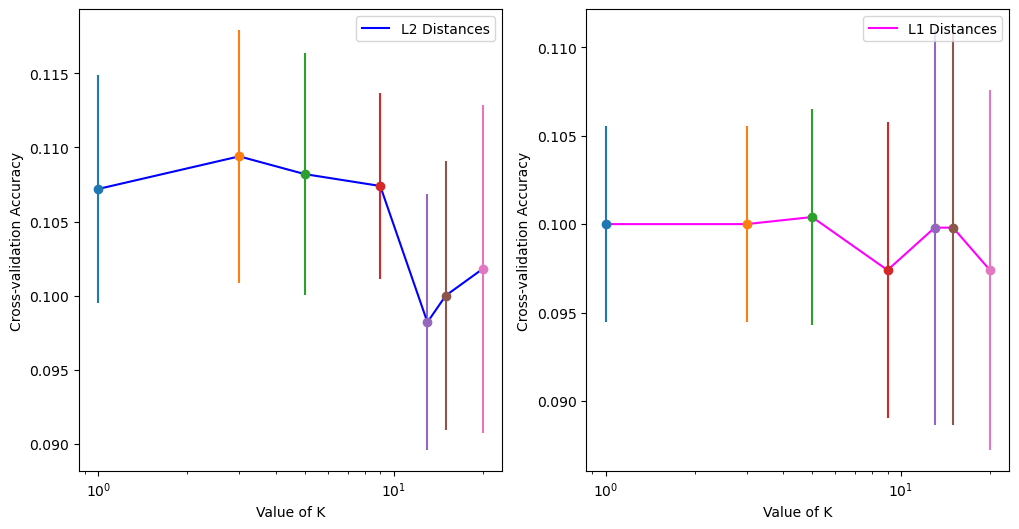

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for k in k_choices:
    accuracies = k_to_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    axs[0].errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')

axs[1].plot(k_choices, [np.mean(k_to_l1_accuracies[k]) for k in k_choices], label='L1 Distances', color='magenta')
axs[1].set_xscale('log')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Cross-validation Accuracy')
axs[1].legend(loc='best')

for k in k_choices:
    accuracies = k_to_l1_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    axs[1].errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')

axs[0].plot(k_choices, [np.mean(k_to_accuracies[k]) for k in k_choices], label='L2 Distances', color='blue')
axs[0].set_xscale('log')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Cross-validation Accuracy')
axs[0].legend(loc='best')

plt.show()

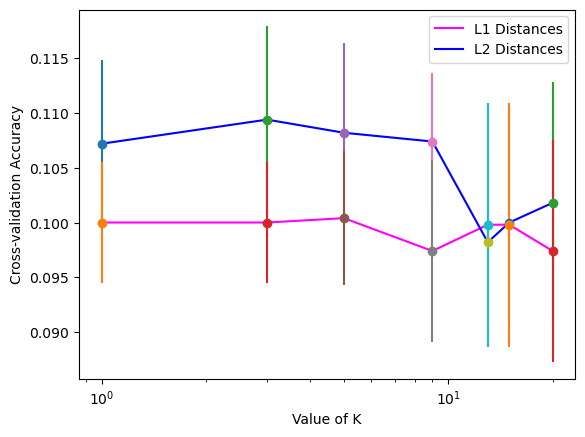

In [39]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    plt.errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')
    
    accuracies = k_to_l1_accuracies[k]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    plt.errorbar(k, mean_accuracy, yerr=std_accuracy, fmt='o')

# Add trend line
plt.plot(k_choices, [np.mean(k_to_l1_accuracies[k]) for k in k_choices], label='L1 Distances', color='magenta')
plt.plot(k_choices, [np.mean(k_to_accuracies[k]) for k in k_choices], label='L2 Distances', color='blue')

plt.xscale('log')
plt.xlabel('Value of K')
plt.ylabel('Cross-validation Accuracy')
plt.legend(loc='best')
plt.show()

Here, we can see L2 is btter than L1.